# Remote Timing Attacks are Practical
_Experiment 6: Attacking SSL applications on the local network._

---

In [3]:
import scipy
import scipy.signal
import seaborn
import sympy
import pandas
import os
import matplotlib.pyplot as plt

from IPython import display
from pprint import pprint

In [4]:
import tls
import attack

## Theory

In [5]:
p = sympy.Integer(11693128827090800677443535237632476895247105886644942164014088484470194179491435241190389270827811769965853291192455791684691555403909415703633832493911789)
q = sympy.Integer(11353860437120204348539420361367294927683441924641720282978666316144621735920188475867378638813811676070362003602263559496393696538309271007870774914687283)
N = sympy.Integer(132762152776056020551326919245624484615462467876809681535549565118332290525598572815747323476102181376625279228965473106140757139049665124368186142774966643990206422037551427526013151129106319233128471783533673959766053786798472937188481868923726256436384468384858420931063093337134977283618537887974322079287)

## Bruteforce Top Few Bits of $q$
The aim of this notebook is to sample the server response times for a bunch of `g` values, and find out if the distribution is meaningfully different between them.

In [7]:
NEIGHBOURHOOD_SIZE = 1600
SAMPLE_SIZE = 20
BRUTEFORCED_BITS = 4

filename = "./measurements/bruteforce-top-bits.txt"
if not os.path.exists(filename):
    gs = attack.bruteforce_most_significant_bits(num_bits=BRUTEFORCED_BITS)
    
    print("Taking {} samples...".format(len(gs)*SAMPLE_SIZE*NEIGHBOURHOOD_SIZE))
    
    raw_samples = attack.sample(
        gs,
        sample_size=SAMPLE_SIZE,
        neighbourhood_size=NEIGHBOURHOOD_SIZE,
        u_g=True,
        N=N,
    )
    samples = pandas.DataFrame.from_records(
        raw_samples,
        columns=["point", "time"],
    )
    samples.to_csv(filename, sep=" ")

else:
    samples = pandas.read_csv(
        filename,
        sep=" ",
        usecols=["point", "time"],
    )

samples['point'] = samples['point'].apply(sympy.Integer)
samples

,point,time
0,6703903964971298549787012499102923063739682910...,3746237
1,6703903964971298549787012499102923063739682910...,3782186
2,6703903964971298549787012499102923063739682910...,3710693
3,6703903964971298549787012499102923063739682910...,3768475
4,6703903964971298549787012499102923063739682910...,3704649
...,...,...
255995,1256981993432118478085064843581798074451190545...,3578153
255996,1256981993432118478085064843581798074451190545...,3658580
255997,1256981993432118478085064843581798074451190545...,3625907
255998,1256981993432118478085064843581798074451190545...,3598474


In the paper, they take median time for each point. By taking the minimum, I hope to extract the fastest time possible, which should be the time with minimal context switches and other delays. This works provided the only sources of unwanted noise _add time_ (rather than remove it).

In [8]:
samples = samples.groupby(by="point").median().reset_index()
samples

,point,time
0,6703903964971298549787012499102923063739682910...,3634961.0
1,6703903964971298549787012499102923063739682910...,3622378.0
2,6703903964971298549787012499102923063739682910...,3610299.0
3,6703903964971298549787012499102923063739682910...,3614746.5
4,6703903964971298549787012499102923063739682910...,3598773.0
...,...,...
12795,1256981993432118478085064843581798074451190545...,3653223.0
12796,1256981993432118478085064843581798074451190545...,3606285.0
12797,1256981993432118478085064843581798074451190545...,3580702.0
12798,1256981993432118478085064843581798074451190545...,3635618.0


We can group samples into their respective "neighbourhoods" considering their most significant bits only.

In [9]:
def point_to_neighbourhood(point):
    point_int = sympy.Integer(point)
    point_bits = attack.sympy_integer_to_bits(point_int)
    neighbourhood_point_bits = point_bits[0:BRUTEFORCED_BITS] + [0] * (512-BRUTEFORCED_BITS)
    neighbourhood_point_int = attack.bits_to_sympy_integer(neighbourhood_point_bits)
    return neighbourhood_point_int

samples['neighbourhood'] = samples['point'].apply(point_to_neighbourhood)

Sum together the measurements in each neighbourhood:

In [10]:
samples = samples.groupby(by="neighbourhood").mean().reset_index()
samples

,neighbourhood,time
0,6703903964971298549787012499102923063739682910...,3.605182e+06
1,7541891960592710868510389061490788446707143274...,3.605513e+06
2,8379879956214123187233765623878653829674603637...,3.604789e+06
3,9217867951835535505957142186266519212642064001...,3.603411e+06
4,1005585594745694782468051874865438459560952436...,3.603837e+06
5,1089384394307836014340389531104224997857698472...,3.604084e+06
6,1173183193869977246212727187343011536154444509...,3.606145e+06
7,1256981993432118478085064843581798074451190545...,3.604822e+06


Since we know the factors of `N` (`q` and `p` with `q<p`) we can consider each point relative in size to these factors. When plotting, we are looking for peaks and troughs near whole multples of `p` and `q`.

In [11]:
sqrt_N = sympy.sqrt(N)
samples['point_relative_to_sqrt_n'] = samples['neighbourhood'].apply(lambda g: round(float(g/sqrt_N), 10))
samples

,neighbourhood,time,point_relative_to_sqrt_n
0,6703903964971298549787012499102923063739682910...,3.605182e+06,0.581823
1,7541891960592710868510389061490788446707143274...,3.605513e+06,0.654551
2,8379879956214123187233765623878653829674603637...,3.604789e+06,0.727278
3,9217867951835535505957142186266519212642064001...,3.603411e+06,0.800006
4,1005585594745694782468051874865438459560952436...,3.603837e+06,0.872734
5,1089384394307836014340389531104224997857698472...,3.604084e+06,0.945462
6,1173183193869977246212727187343011536154444509...,3.606145e+06,1.018190
7,1256981993432118478085064843581798074451190545...,3.604822e+06,1.090918


In [12]:
q_relative_to_sqrt_n = round(float(q/sqrt_N), 10)
p_relative_to_sqrt_n = round(float(p/sqrt_N), 10)

Now plot the media response time as we vary `g`:

In [13]:
smallest_time_observed = samples['time'].min()
largest_time_observed = samples['time'].max()

buffer = (largest_time_observed - smallest_time_observed)/10

smallest_time_observed, largest_time_observed, buffer

(3603410.596875, 3606144.5403125, 273.3943437500391)

In [14]:
if SAMPLE_SIZE == 20 and NEIGHBOURHOOD_SIZE == 800 or True:
    error = 27442/(2*6529841)
elif SAMPLE_SIZE == 7 and NEIGHBOURHOOD_SIZE == 400:
    error = 42987/(2*6500856)
else:
    error = 0

In [15]:
ylim = (
    smallest_time_observed * (1 - error) - buffer,
    largest_time_observed * (1 + error) + buffer,
)

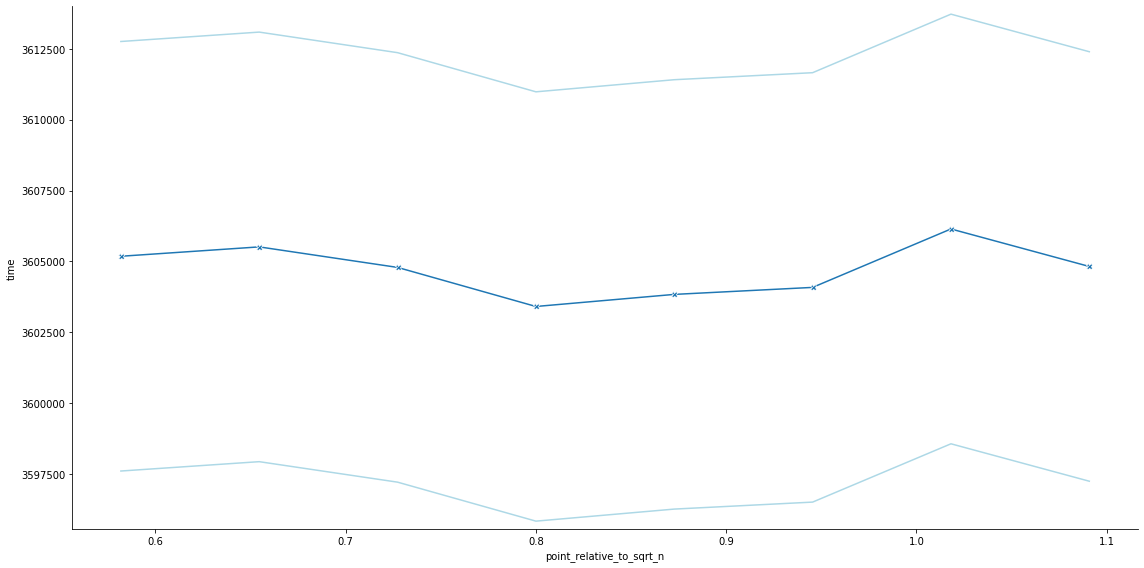

In [16]:
g = seaborn.relplot(data=samples, x='point_relative_to_sqrt_n', y='time', kind='line', height=8, aspect=16/8, marker="X")
if error:
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1+error) for y in samples['time']], color='lightblue')
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1-error) for y in samples['time']], color='lightblue')
g.set(ylim=ylim)
g

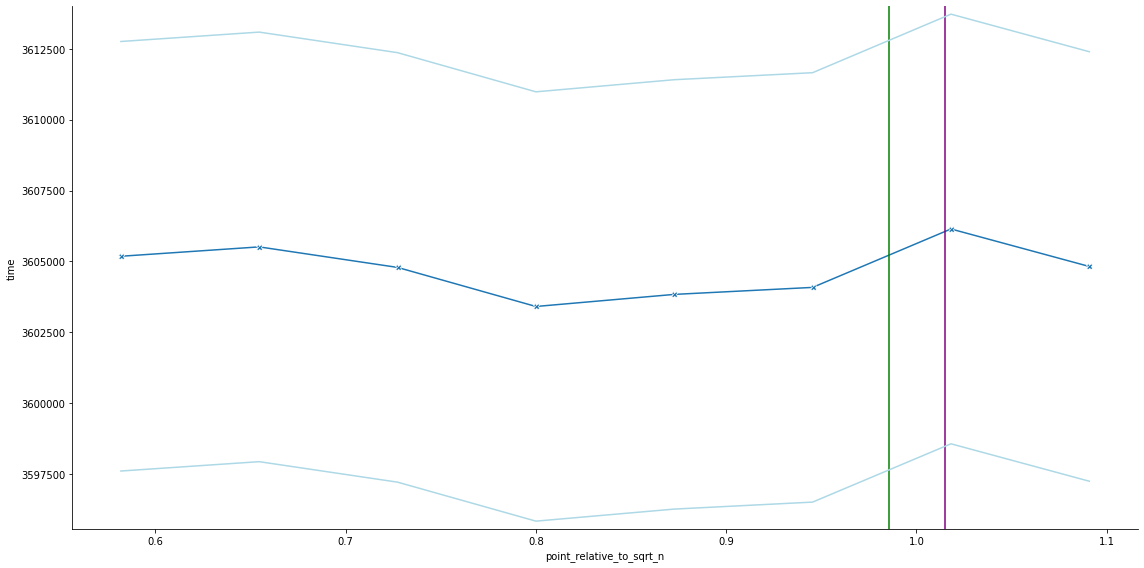

In [17]:
g = seaborn.relplot(data=samples, x='point_relative_to_sqrt_n', y='time', kind='line', height=8, aspect=16/8, marker="X")
plt.plot([q_relative_to_sqrt_n, q_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='green')
plt.plot([p_relative_to_sqrt_n, p_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='purple')
if error:
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1+error) for y in samples['time']], color='lightblue')
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1-error) for y in samples['time']], color='lightblue')
g.set(ylim=ylim)
g

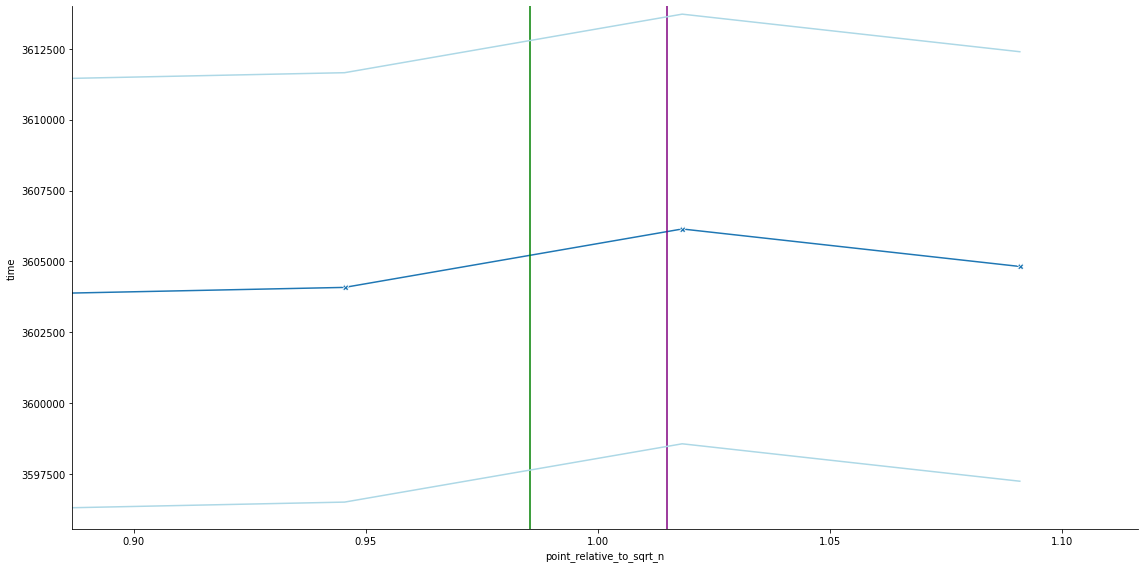

In [18]:
g = seaborn.relplot(data=samples, x='point_relative_to_sqrt_n', y='time', kind='line', height=8, aspect=16/8, marker="X")
plt.plot([q_relative_to_sqrt_n, q_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='green')
plt.plot([p_relative_to_sqrt_n, p_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='purple')
if error:
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1+error) for y in samples['time']], color='lightblue')
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1-error) for y in samples['time']], color='lightblue')
g.set(ylim=ylim)
g.set(xlim=(q_relative_to_sqrt_n*0.9, p_relative_to_sqrt_n*1.1))
g

In the section below, we bound the value of $q$ using the shape of this graph. But its worth noting that the peaks and troughs in the graphs above fit well inside the error bars (calculated in the `noise.ipynb` notebook). It is likely this graph should just be a straight line. 

### Bounding our search for `q`

`scipy` finds two peaks in the sample set.

In [19]:
peak_indices, _ = scipy.signal.find_peaks(samples['time'])
len(peak_indices)

2

Lets re-plot the above graph with the peaks highlighted:

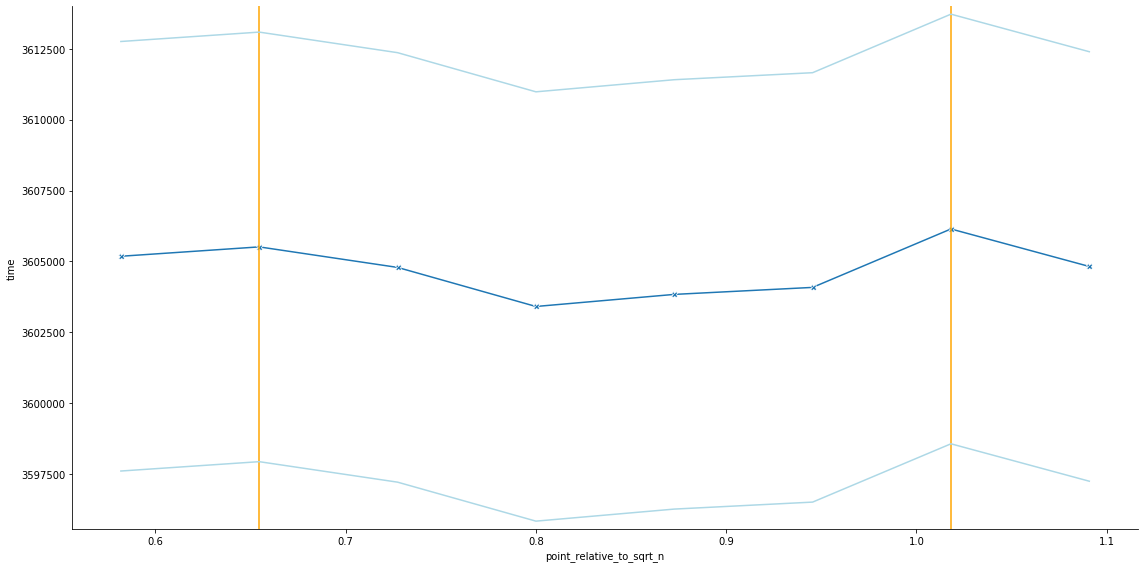

In [20]:
g = seaborn.relplot(data=samples, x='point_relative_to_sqrt_n', y='time', kind='line', height=8, aspect=16/8, marker="X")

for peak_index in peak_indices:
    peak = samples.iloc[peak_index]
    plt.plot([peak['point_relative_to_sqrt_n'], peak['point_relative_to_sqrt_n']], ylim, color='orange')

if error:
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1+error) for y in samples['time']], color='lightblue')
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1-error) for y in samples['time']], color='lightblue')
g.set(ylim=ylim)
g

I'm going to cheat a little and say that the first peak they've detected isn't quite a peak. We could have modified the `find_peaks` call to be more discerning, or fit a KDE to it, but I think its relatively clear the primary peak is the second value they've detected.

In [21]:
peak_index = 1
peak_row = samples.iloc[peak_indices[1]]
peak_g = peak_row['neighbourhood']

In [22]:
attack.sympy_integer_to_bits(peak_g)[0:BRUTEFORCED_BITS]

[1, 1, 1, 0]

This gives a lower bound on `q`. To get an upper bound on `q`, note the following:
  1. $q*p = N$
  2. $q < p$

From 1. and 2. it follows that $q < \sqrt{N}$.

(Suppose $q >= \sqrt{N}$, then by 2. $p > \sqrt{N}$ and so $ q*p > N$ which contradicts 1. Therefore $q < \sqrt{N}$.)

In [23]:
lower_bound = peak_g
upper_bound = sympy.Integer(sqrt_N.round())

lower_bound, upper_bound

(11731831938699772462127271873430115361544445093018344205508116263256543526314353604701640010896040499228777875913175294497034647460453248703129442880323584,
 11522245995293453226444537667133610590574234209345464522156603069988519317090416103523895551843843150180734266788088596830720220822331432054108383719953516)

Let's plot these two bounds on the graph:

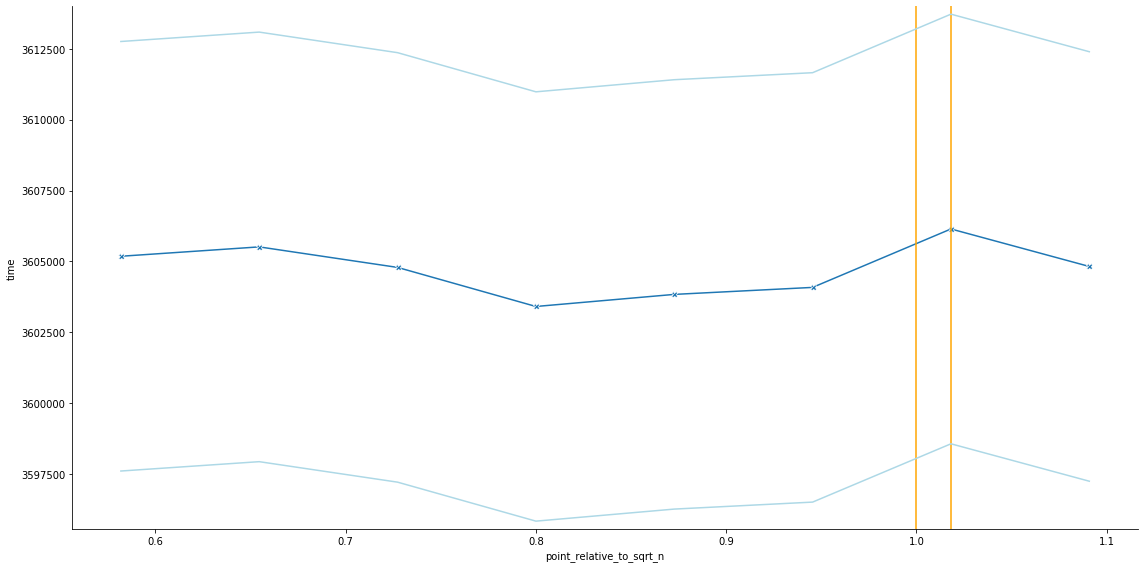

In [24]:
lower_bound_relative_to_sqrt_n = round(float(lower_bound/sqrt_N), 10)
upper_bound_relative_to_sqrt_n = round(float(upper_bound/sqrt_N), 10)

g = seaborn.relplot(data=samples, x='point_relative_to_sqrt_n', y='time', kind='line', height=8, aspect=16/8, marker="X")

plt.plot([lower_bound_relative_to_sqrt_n, lower_bound_relative_to_sqrt_n], ylim, color='orange')
plt.plot([upper_bound_relative_to_sqrt_n, upper_bound_relative_to_sqrt_n], ylim, color='orange')

if error:
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1+error) for y in samples['time']], color='lightblue')
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1-error) for y in samples['time']], color='lightblue')
g.set(ylim=ylim)
g

Lets consider the bit representations of these two bounds so we can set in stone the first few bits.

In [25]:
print("Lower Bound:", attack.sympy_integer_to_bits(lower_bound)[0:BRUTEFORCED_BITS])
print("Upper Bound:", attack.sympy_integer_to_bits(upper_bound)[0:BRUTEFORCED_BITS])

Lower Bound: [1, 1, 1, 0]
Upper Bound: [1, 1, 0, 1]


In [26]:
lower_bound_bits = attack.sympy_integer_to_bits(lower_bound)
upper_bound_bits = attack.sympy_integer_to_bits(upper_bound)

known_q_bits = []
for i in range(BRUTEFORCED_BITS):
    if lower_bound_bits[i] == upper_bound_bits[i]:
        known_q_bits.append(lower_bound_bits[i])
    else:
        break
        
known_q_bits

[1, 1]

The above giving us the first bits of $q$.

Since it is prime, we also know that $q$ is odd, and so its least significant bit is 1. We'll ignore that for now.

# Recovering Bits of $q$

Run the iterative key recovery attack on bits 1, 2, and 3. We already know their true values, so there zero-one gaps can be used as reference points for the other bits.

In [24]:
# BITS_TO_RECOVER = 100

In [25]:
# q_bits = attack.sympy_integer_to_bits(q)

In [26]:
# bit_samples_filename = "./measurements/bit-samples.txt"
# bit_samples = pandas.DataFrame({
#     'bit_position': [],
#     'bit_value': [],
#     'point': [],
#     'time': [],
# })

In [27]:
# bits = []
# for i in range(0, 4):
#     g_low_samples, g_high_samples = attack.sample_ith_bit(
#         q_bits,
#         i,
#         sample_size=SAMPLE_SIZE,
#         neighbourhood_size=NEIGHBOURHOOD_SIZE,
#     )
        
#     g_low_samples['bit_position'] = i
#     g_low_samples['bit_value'] = 0
    
#     g_high_samples['bit_position'] = i
#     g_high_samples['bit_value'] = 1
    
#     bit_samples = pandas.concat([bit_samples, g_low_samples, g_high_samples], axis=0, sort=True)
    
# bit_samples.to_csv(bit_samples_filename, sep=" ")

In [28]:
# @DAN: Plot the distributions like I did with the bruteforcing back in the day?

There's a reasonable midpoint which could be used to separate the zeroes from the ones above. So lets continue and see what we get. Note that from here onwards, I've used the _correct_ bits of q, not the one the algorithm has picked, so there is a little cheating going on in the below.

In [29]:
# for i in range(4, BITS_TO_RECOVER):
#     g_low_samples, g_high_samples = attack.sample_ith_bit(
#         q_bits,
#         i,
#         sample_size=SAMPLE_SIZE,
#         neighbourhood_size=NEIGHBOURHOOD_SIZE,
#     )
        
#     g_low_samples['bit_position'] = i
#     g_low_samples['bit_value'] = 0
    
#     g_high_samples['bit_position'] = i
#     g_high_samples['bit_value'] = 1
    
#     bit_samples = pandas.concat([bit_samples, g_low_samples, g_high_samples], axis=0, sort=True)
    
#     if i%5 == 0:
#         bit_samples.to_csv(bit_samples_filename, sep=" ")

# bit_samples.to_csv(bit_samples_filename, sep=" ")

Plot them so we can contrast their distributions:

In [30]:
# zero_one_gaps = pandas.DataFrame({
#     'True Value': q_bits[1:BITS_TO_RECOVER],
#     'Zero-One Gap': gaps,
#     'Bit': range(1, BITS_TO_RECOVER),
# })

In [31]:
# seaborn.relplot(
#     data=zero_one_gaps,
#     x='Bit',
#     y='Zero-One Gap',
#     hue='True Value',
#     kind='scatter',
#     height=8,
#     aspect=16/8,
# )

No midpoint exists which allows us to separate the two groups perfectly.

## Coppersmiths Attack

## References
  - [1] https://crypto.stanford.edu/~dabo/papers/ssl-timing.pdf